# Sparkify Project Workspace
This workspace uses the tiny subset (128MB) of the full dataset available (12GB).

## Table of Content
- [Project Informations](#infos)
- [Load and Clean Dataset](#prepro)
- [Exploratory Data Analysis](#analysis)
- [Feature Engineering](#feats)
- [Modeling](#models)
- [Conclusion](#conclusion)

# Project Informations <a id='infos'></a>
This workspace uses the tiny subset (128MB) of the full dataset available (12GB).



# Load and Clean Dataset <a id='prepro'></a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

In [6]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, sum, concat, desc, asc, explode, lit, min, max, split, udf, lit, when, lower
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth, hour, weekofyear, date_format, datediff
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
from time import time
import pandas as pd

In [7]:
# create a Spark session
spark = SparkSession.builder \
    .appName("Sparkify") \
    .getOrCreate()

In [8]:
# spark session information 
spark

In [9]:
#for better visibility using jupyter notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [10]:
#read mini-dataset file into spark session
df = spark.read.json('../data/mini_sparkify_event_data.json')

In [11]:
# insight to data structure
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [12]:
#  Dataset Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
# count number of values per column
df.describe().show(1,vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



In [14]:
# number of unique rows
df.distinct().count()

286500

In [15]:
# number of sessions
df.select('sessionId').distinct().count()

2354

In [17]:
# list of values for columns 'page'
df.select('page').distinct().show(25)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
| Submit Registration|
|            Register|
+--------------------+



In [18]:
def clean_df(spark, df=df):
    '''
    cleaning database
    : INPUT
    spark - spark session
    df - dataframe
    :OUTPUT
    df- cleaned Dataframe
    '''
    
    #filter empty values in userId
    df=df.filter(df.userId != '')
    
    # create new columns with iso timestamp using ts and registration columns
    df=df.withColumn('event_timestamp', to_timestamp(df['ts']/1000))
    df=df.withColumn('registration_timestamp', to_timestamp(df['registration']/1000))
    df=df.withColumn('days_registered', datediff(df['event_timestamp'],df['registration_timestamp']))
    
    # create new columns for device and device_os using userAgent column
    df=df.withColumn('device', 
                      when(lower(df.userAgent).contains('windows'), lit('computer'))
                      .when(lower(df.userAgent).contains('macintosh'), lit('computer'))
                      .when(lower(df.userAgent).contains('linux'), lit('computer'))
                      .when(lower(df.userAgent).contains('mobile'), lit('mobile'))
                      .otherwise(lit('other')) )

    df=df.withColumn('device_os', 
                      when(lower(df.userAgent).contains('windows'), lit('windows'))
                      .when(lower(df.userAgent).contains('mac'), lit('mac'))
                      .when(lower(df.userAgent).contains('linux'), lit('linux'))
                      .otherwise(lit('other')) )
    
    #split lacation into seperate city and state columns
    df=df.withColumn('city', split(df['location'],',').getItem(0))
    df=df.withColumn('state', split(df['location'],',').getItem(1))
    
    # create churn_event and downgrade_event columns from page columns
    df=df.withColumn('churn_event', 
                      when(df.page.contains('Cancellation Confirmation'), lit(1))
                      .otherwise(lit(0)) )
    df=df.withColumn('downgrade_event', 
                      when(df.page.contains('Submit Downgrade'), lit(1))
                      .otherwise(lit(0)) )
    
    return df

df=clean_df(spark, df)

In [19]:
# show structure of cleaned dataset
df.show(20)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+---------------+--------+---------+--------------------+------+-----------+---------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|    event_timestamp|registration_timestamp|days_registered|  device|device_os|                city| state|churn_event|downgrade_event|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+---------

In [20]:
# show earliest and latest timestamp for events and registrations
df.agg(min('event_timestamp'),max('event_timestamp'),min('registration_timestamp'),max('registration_timestamp')).show()

+--------------------+--------------------+---------------------------+---------------------------+
|min(event_timestamp)|max(event_timestamp)|min(registration_timestamp)|max(registration_timestamp)|
+--------------------+--------------------+---------------------------+---------------------------+
| 2018-10-01 02:01:57| 2018-12-03 02:11:16|        2018-03-18 14:44:35|        2018-11-26 16:49:14|
+--------------------+--------------------+---------------------------+---------------------------+



# Exploratory Data Analysis<a id='analysis'></a>


In [21]:
# creates a table of user variables
df.createOrReplaceTempView("events")
user_table = spark.sql("""
                        SELECT 
                            u.userId as user_id, 
                            u.firstName as first_name, 
                            u.lastName as last_name, 
                            u.gender as gender, 
                            u.city as city,
                            u.state as state,
                            u.device as device,
                            u.device_os as device_os,
                            u.registration_timestamp as registration_timestamp,
                            p.free_account,
                            p.paid_account,
                            p.churned as churned,
                            date_format(p.churn_timestamp, 'EEEE') as churn_weekday,
                            hour(p.churn_timestamp) as churn_hour,
                            datediff(p.churn_timestamp,u.registration_timestamp) as days_till_churned,
                            p.downgraded as downgraded,
                            p.session_count as session_count,
                            (p.song_count/p.nextsong_count) as song_ratio,
                            (p.artist_count/p.nextsong_count) as artist_ratio,
                            p.nextsong_count as nextsong_count,
                            p.likes_count as likes_count,
                            p.dislike_count as dislike_count,
                            p.error_count as error_count,
                            p.help_count as help_count,
                            (p.likes_count/p.song_count) as likes_ratio,
                            (p.dislike_count/p.song_count) as dislike_ratio,
                            
                            p.event_count as event_count
                        FROM (SELECT DISTINCT
                                    userId , 
                                    firstName, 
                                    lastName, 
                                    gender, 
                                    location,
                                    city,
                                    state,
                                    userAgent,
                                    device,
                                    device_os ,
                                    registration ,
                                    registration_timestamp 
                                FROM events) AS u
                        JOIN (SELECT DISTINCT
                                    userId, 
                                    (CASE WHEN COUNT(CASE WHEN level='free' THEN 1 ELSE NULL END)>0 THEN 1 ELSE 0 END) as free_account,
                                    (CASE WHEN COUNT(CASE WHEN level='paid' THEN 1 ELSE NULL END)>0 THEN 1 ELSE 0 END) as paid_account,
                                    MAX(churn_event) as churned,
                                    MAX(downgrade_event) as downgraded,
                                    COUNT(DISTINCT sessionId) as session_count,
                                    COUNT(DISTINCT song) as song_count,
                                    COUNT(DISTINCT artist) as artist_count,
                                    COUNT(CASE WHEN page='NextSong' THEN 1 ELSE NULL END) as nextsong_count,
                                    COUNT(CASE WHEN page=='Thumbs Up' THEN 1 ELSE NULL END) as likes_count,
                                    COUNT(CASE WHEN page=='Thumbs Down' THEN 1 ELSE NULL END) as dislike_count,
                                    COUNT(CASE WHEN page=='Error' THEN 1 ELSE NULL END) as error_count,
                                    COUNT(CASE WHEN page=='Help' THEN 1 ELSE NULL END) as help_count,
                                    (CASE WHEN MAX(churn_event)>0 THEN MAX(event_timestamp) ELSE NULL END) as churn_timestamp,
                                    COUNT(*) as event_count
                                FROM events GROUP BY userId) AS p
                        ON u.userId=p.userId
                        ORDER BY user_id
                        """)

user_table.show(5)

+-------+----------+---------+------+--------------------+-----+--------+---------+----------------------+------------+------------+-------+-------------+----------+-----------------+----------+-------------+------------------+------------------+--------------+-----------+-------------+-----------+----------+--------------------+--------------------+-----------+
|user_id|first_name|last_name|gender|                city|state|  device|device_os|registration_timestamp|free_account|paid_account|churned|churn_weekday|churn_hour|days_till_churned|downgraded|session_count|        song_ratio|      artist_ratio|nextsong_count|likes_count|dislike_count|error_count|help_count|         likes_ratio|       dislike_ratio|event_count|
+-------+----------+---------+------+--------------------+-----+--------+---------+----------------------+------------+------------+-------+-------------+----------+-----------------+----------+-------------+------------------+------------------+--------------+---------

In [22]:
# transform user_table to pandas Dataframe
df_user=user_table.toPandas().set_index('user_id')

# changing values for columns 'churned' and 'downgraded'
df_user['churned']=df_user['churned'].map({0:'stayed', 1:'churned'})
df_user['downgraded']=df_user['downgraded'].map({0:'kept level', 1:'downgraded'})
df_user.head()


C:\Users\thoma\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,first_name,last_name,gender,city,state,device,device_os,registration_timestamp,free_account,paid_account,...,song_ratio,artist_ratio,nextsong_count,likes_count,dislike_count,error_count,help_count,likes_ratio,dislike_ratio,event_count
user_id,,,,,,,,,,,,,,,,,,,,,
10,Brycen,Bradley,M,Laurel,MS,computer,mac,2018-09-28 20:31:35,0,1,...,0.934621,0.839525,673,37,4,0,1,0.058824,0.006359,795
100,Colin,Larson,M,Dallas-Fort Worth-Arlington,TX,computer,windows,2018-09-26 19:17:35,1,1,...,0.858315,0.635720,2682,148,27,3,18,0.064292,0.011729,3214
100001,Delaney,Perez,F,Miami-Fort Lauderdale-West Palm Beach,FL,computer,mac,2018-08-18 23:24:26,1,0,...,0.969925,0.939850,133,8,2,1,1,0.062016,0.015504,187
100002,Gracie,Chang,F,Santa Maria-Santa Barbara,CA,computer,windows,2018-06-25 15:51:29,0,1,...,0.989744,0.943590,195,5,0,0,0,0.025907,0.000000,218
100003,Nevaeh,Jones,F,Miami-Fort Lauderdale-West Palm Beach,FL,computer,windows,2018-09-19 00:22:24,1,0,...,1.000000,0.980392,51,3,0,0,1,0.058824,0.000000,78


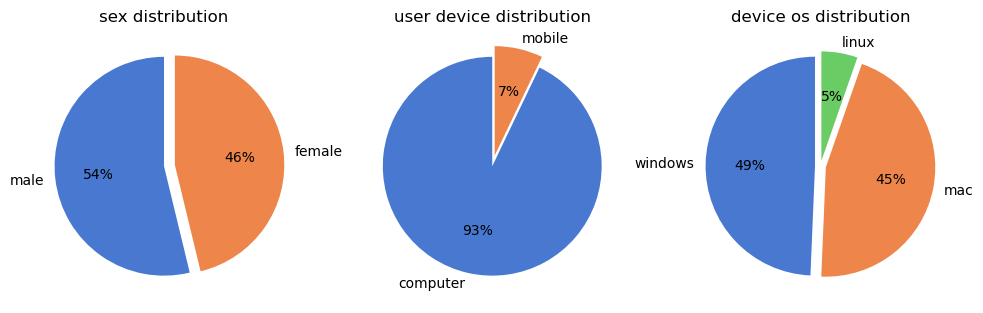

In [49]:
# Getting insights in basic user features
colors=sns.color_palette('muted')
# plotting pie charts for user distribution for sex, devices and their OS beeing used, 
fig, axs = plt.subplots(1, 3, figsize=[12,5])

axs[0].set_title("sex distribution")
axs[0].pie(df_user.gender.value_counts(), labels=['male', 'female'],explode=(0,0.1),autopct='%.0f%%',startangle=90, colors=colors );

axs[1].set_title('user device distribution')
axs[1].pie(df_user.device.value_counts(), labels=df_user.device.value_counts().index.tolist(),explode=(0,0.1),autopct='%.0f%%',startangle=90, colors=colors );

axs[2].set_title('device os distribution')
axs[2].pie(df_user.device_os.value_counts(), labels=df_user.device_os.value_counts().index.tolist(),explode=(0.05 ,0.05,0.05),autopct='%.0f%%',startangle=90, colors=colors );



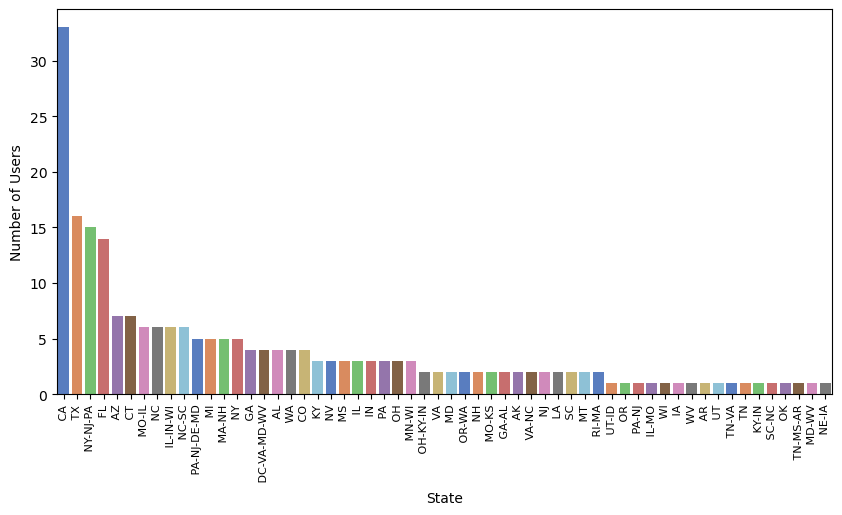

In [51]:
#bar plot for number of users by state
plt.figure( figsize=[10,5])
ax=sns.barplot(x=df_user.state.value_counts().index,y=df_user.state.value_counts(),palette='muted');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.xlabel('State')
plt.ylabel('Number of Users');

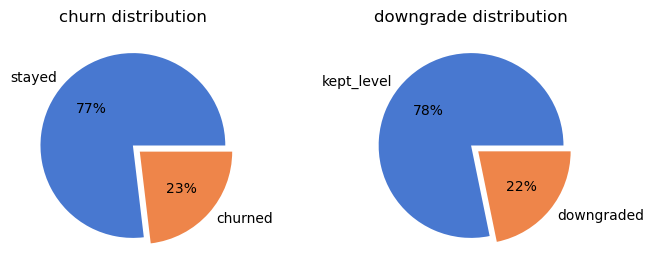

In [52]:
# plotting pie charts for distribution for churned and downgraded users 
fig, axs = plt.subplots(1, 2, figsize=[8,3])
axs[0].set_title("churn distribution")
axs[0].pie(df_user.churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );

axs[1].set_title("downgrade distribution")
axs[1].pie(df_user.downgraded.value_counts(), labels=[ 'kept_level','downgraded'],explode=(0,0.1),autopct='%.0f%%', colors=colors );

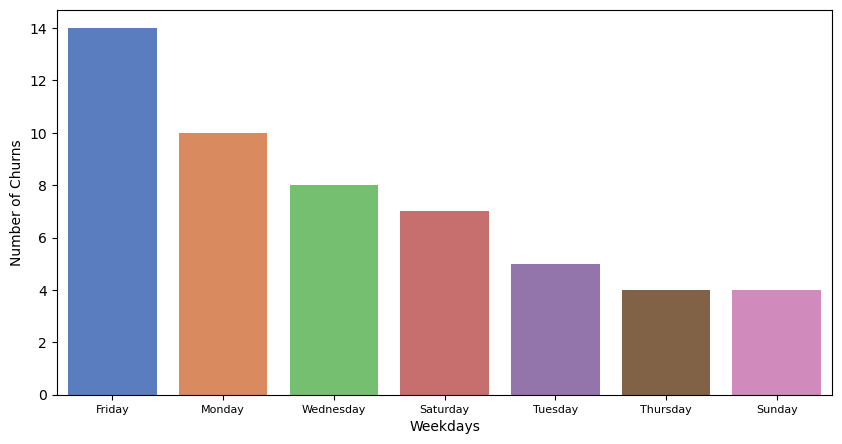

In [53]:
# bar plot number of churns per weekday
plt.figure( figsize=[10,5])
ax=sns.barplot(x=df_user[df_user.churned=='churned'].churn_weekday.value_counts().index,y=df_user[df_user.churned=='churned'].churn_weekday.value_counts(),palette='muted');
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.xlabel('Weekdays')
plt.ylabel('Number of Churns');

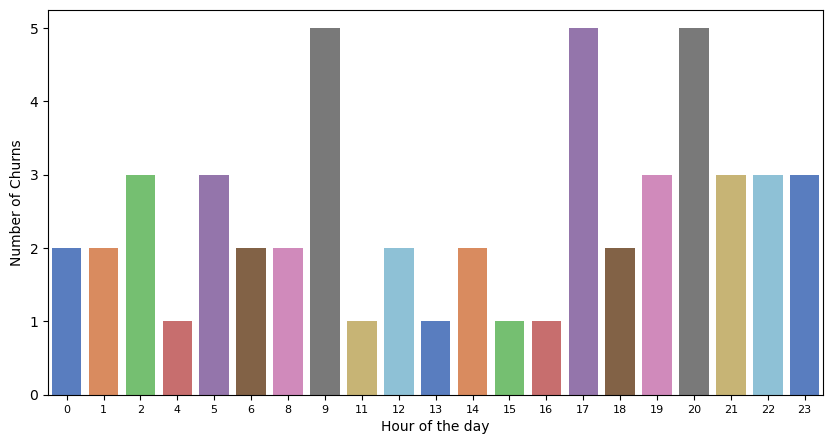

In [54]:
# bar plot number of churns per hour of the day
plt.figure( figsize=[10,5])
ax=sns.barplot(x=df_user[df_user.churned=='churned'].churn_hour.value_counts().index.astype('int'),y=df_user[df_user.churned=='churned'].churn_hour.value_counts(),palette='muted');
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.xlabel('Hour of the day')
plt.ylabel('Number of Churns');

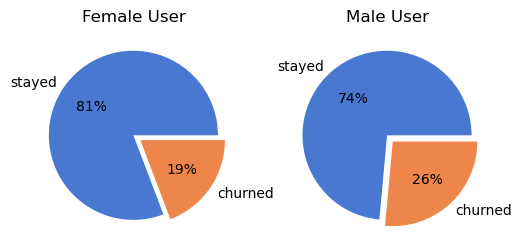

In [67]:
# pie plot for churn distribution per sex
fig, axs = plt.subplots(1, 2, figsize=[6,3])
axs[0].pie(df_user[df_user['gender']=='F'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[0].set_title('Female User')

axs[1].pie(df_user[df_user['gender']=='M'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[1].set_title('Male User');

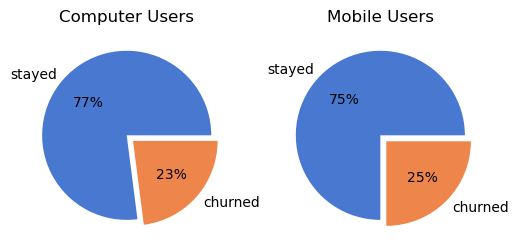

In [56]:
# pie plot for churn distribution per user device
fig, axs = plt.subplots(1, 2, figsize=[6,3])
axs[0].pie(df_user[df_user['device']=='computer'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[0].set_title('Computer Users')

axs[1].pie(df_user[df_user['device']=='mobile'].churned.value_counts(), labels=['stayed', 'churned'],explode=(0,0.1),autopct='%.0f%%', colors=colors );
axs[1].set_title('Mobile Users');

In [69]:
#defining function to equaly barplot features
def barplot_userfeatures(df,features, hue,title, xlabel, ylabel):
    '''Plot barplot for features'''
    temp=df[[hue]+features].groupby([hue]).mean().unstack().reset_index()
    temp.columns=['features',hue,'value']
    
    ax=sns.catplot(data=temp,x='features',y='value',hue=hue ,kind="bar", palette="muted", height=3, aspect=2 )
    ax.set_axis_labels(xlabel,ylabel)
    ax.set_xticklabels(list(map(lambda x: x.split('_')[0], features)))
    ax.legend.set_title(title);

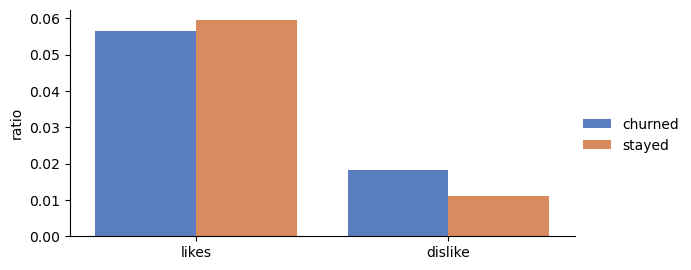

In [70]:
#comparing likes- and dislike-ratio (likes/dislikes per songs listened) for churned and stayed users
barplot_userfeatures(df=df_user,features=['likes_ratio', 'dislike_ratio'],hue='churned',xlabel='',ylabel='ratio',title='')

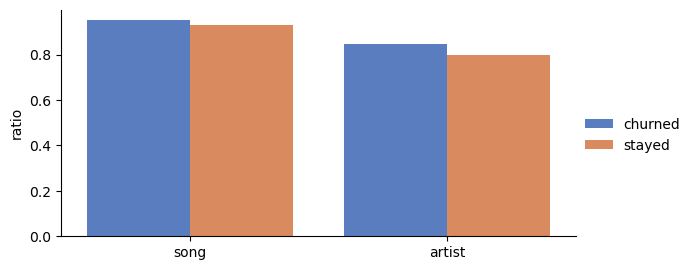

In [71]:
#comparing song- and artist-ratio (songs/artists per event) for churned and stayed users
barplot_userfeatures(df=df_user,features=['song_ratio', 'artist_ratio'],hue='churned',xlabel='',ylabel='ratio',title='')

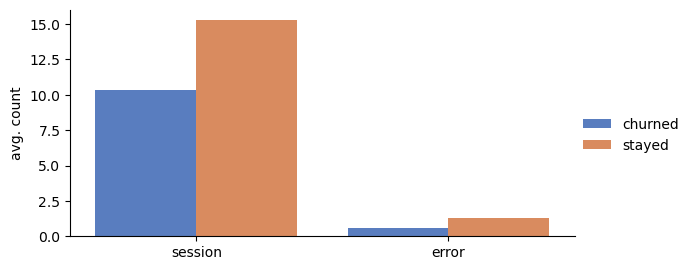

In [72]:
#comparing session- and error-count for churned and stayed users
barplot_userfeatures(df=df_user,features=['session_count', 'error_count'],hue='churned',xlabel='',ylabel='avg. count',title='')

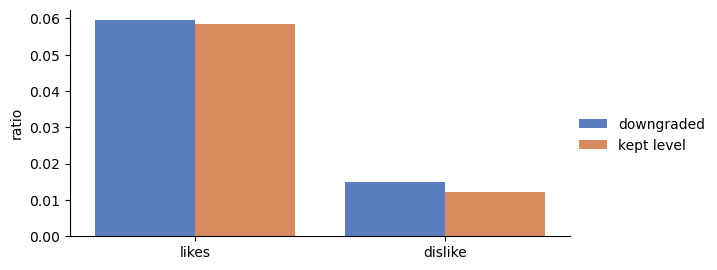

In [76]:
#comparing like- and dislike-ratio (likes/dislikes per song listened) for downgraded users and users who didn't
barplot_userfeatures(df=df_user,features=['likes_ratio', 'dislike_ratio'],hue='downgraded',xlabel='',ylabel='ratio',title='')

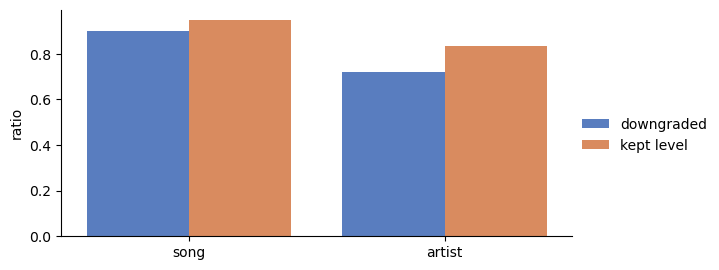

In [75]:
#comparing song- and artist-ratio (songs/artists per event) for downgraded users and users who didn't
barplot_userfeatures(df=df_user,features=['song_ratio', 'artist_ratio'],hue='downgraded',xlabel='',ylabel='ratio',title='')

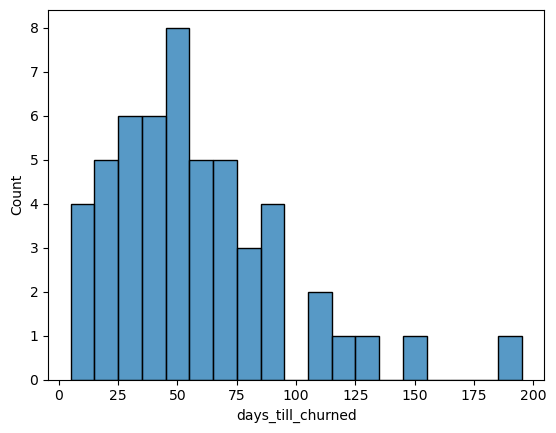

In [80]:
# histogram for duration of registration
sns.histplot(data=df_user[df_user.churned=='churned'], x='days_till_churned',binwidth=10);

# Feature Engineering <a id='feats'></a>


In [82]:
# create table for event variables
df.createOrReplaceTempView("events")
event_table = spark.sql("""
                    SELECT DISTINCT
                        userId as user_id,
                        sessionId as session_id,
                        itemInSession as item_in_session,
                        page as event,
                        auth,
                        level,
                        ts as event_timestamp_unix,
                        event_timestamp,
                        days_registered,
                        churn_event,
                        downgrade_event
                    FROM events
                    ORDER BY event_timestamp_unix DESC
                """) 
event_table.show(5)

+-------+----------+---------------+--------+---------+-----+--------------------+-------------------+---------------+-----------+---------------+
|user_id|session_id|item_in_session|   event|     auth|level|event_timestamp_unix|    event_timestamp|days_registered|churn_event|downgrade_event|
+-------+----------+---------------+--------+---------+-----+--------------------+-------------------+---------------+-----------+---------------+
| 100002|       198|              0|NextSong|Logged In| paid|       1543799476000|2018-12-03 02:11:16|            161|          0|              0|
| 200008|       408|            133|NextSong|Logged In| paid|       1543622579000|2018-12-01 01:02:59|            116|          0|              0|
|    152|      2409|             37|NextSong|Logged In| paid|       1543622432000|2018-12-01 01:00:32|             31|          0|              0|
| 300011|       500|             45|NextSong|Logged In| paid|       1543622411000|2018-12-01 01:00:11|             62|

In [83]:
# create feature avg number of songs per session
songs_session=event_table.filter(event_table['event']=='NextSong').groupby(['user_id','session_id']).count().orderBy(['user_id','session_id'])
songs_session=songs_session.select(['user_id','count']).groupby('user_id').mean('count').withColumnRenamed('avg(count)','avg_songs_session')
songs_session.show()

+-------+------------------+
|user_id| avg_songs_session|
+-------+------------------+
| 100010|39.285714285714285|
| 200002|              64.5|
|    125|               8.0|
|     51|             211.1|
|    124|145.67857142857142|
|      7|21.428571428571427|
|     54| 81.17142857142858|
|     15|136.71428571428572|
|    155|136.66666666666666|
| 100014|42.833333333333336|
|    132|             120.5|
|    154|              28.0|
|    101|             179.7|
|     11|           40.4375|
| 300017|59.540983606557376|
|    138|             138.0|
|     29| 89.05882352941177|
|     69|             125.0|
| 100021|              46.0|
|     42| 87.14634146341463|
+-------+------------------+
only showing top 20 rows



In [84]:
# create feature avg session duration
session_time=event_table.groupby(['user_id','session_id']).agg((max('event_timestamp').cast('long')-min('event_timestamp').cast('long')).alias('session_time_sec')).orderBy(['user_id','session_id'])
session_time=session_time.groupby('user_id').mean('session_time_sec').withColumnRenamed('avg(session_time_sec)','avg_session_time_sec')
session_time.show()

+-------+--------------------+
|user_id|avg_session_time_sec|
+-------+--------------------+
| 100010|              9269.0|
| 200002|             15984.0|
|    125|              1774.0|
|     51|             52341.4|
|    124|   34739.65517241379|
|      7|   5258.428571428572|
|     54|   19337.37837837838|
|     15|             31697.0|
|    155|  32914.333333333336|
| 100014|  11088.833333333334|
|    132|          29937.0625|
|    154|              6641.0|
|    101|             49054.8|
|     11|            9682.625|
| 300017|  13999.444444444445|
|    138|             33853.6|
|     29|   21945.41176470588|
|     69|   31601.11111111111|
| 100021|             12913.6|
|     42|   19773.76595744681|
+-------+--------------------+
only showing top 20 rows



In [85]:
#create feature table

user_table.createOrReplaceTempView("user_table")
songs_session.createOrReplaceTempView('song_session')
session_time.createOrReplaceTempView('session_time')

features=spark.sql("""
                    SELECT 
                        INT(u.user_id) as user_id,
                        u.female as female,
                        u.male as male,
                        u.device_pc as device_pc,
                        u.device_mobile as device_mobile,
                        u.os_windows as os_windows,
                        u.os_mac as os_mac,
                        u.os_linux as os_linux,
                        u.free_account as free_account,
                        u.paid_account as paid_account,
                        u.churned as churned,
                        u.downgraded as downgraded,
                        u.session_count as session_count,
                        u.nextsong_count as nextsong_count,
                        u.likes_count as likes_count,
                        u.dislike_count as dislike_count,
                        u.help_count as help_count,
                        u.error_count as error_count,
                        u.event_count as event_count,
                        s.avg_songs_session as avg_songs_session,
                        t.avg_session_time_sec as avg_session_time_sec
                    
                    FROM
                        (SELECT 
                            user_id,
                            (CASE WHEN gender='F' THEN 1 ELSE 0 END) as female,
                            (CASE WHEN gender='M' THEN 1 ELSE 0 END) as male,
                            (CASE WHEN device='computer' THEN 1 ELSE 0 END) as device_pc,
                            (CASE WHEN device='mobile' THEN 1 ELSE 0 END) as device_mobile,
                            (CASE WHEN device_os='windows' THEN 1 ELSE 0 END) as os_windows,
                            (CASE WHEN device_os='mac' THEN 1 ELSE 0 END) as os_mac,
                            (CASE WHEN device_os='linux' THEN 1 ELSE 0 END) as os_linux,
                            free_account,
                            paid_account,
                            churned,
                            downgraded,
                            session_count,
                            nextsong_count,
                            likes_count,
                            dislike_count,
                            help_count,
                            error_count,
                            event_count
                        FROM user_table) as u
                    JOIN (SELECT * FROM song_session) as s
                    ON u.user_id=s.user_id
                    JOIN (SELECT * FROM session_time) as t
                    ON u.user_id=t.user_id
                        """)
features.show(5)                        

+-------+------+----+---------+-------------+----------+------+--------+------------+------------+-------+----------+-------------+--------------+-----------+-------------+----------+-----------+-----------+------------------+--------------------+
|user_id|female|male|device_pc|device_mobile|os_windows|os_mac|os_linux|free_account|paid_account|churned|downgraded|session_count|nextsong_count|likes_count|dislike_count|help_count|error_count|event_count| avg_songs_session|avg_session_time_sec|
+-------+------+----+---------+-------------+----------+------+--------+------------+------------+-------+----------+-------------+--------------+-----------+-------------+----------+-----------+-----------+------------------+--------------------+
| 100010|     1|   0|        0|            1|         0|     1|       0|           1|           0|      0|         0|            7|           275|         17|            5|         2|          0|        381|39.285714285714285|              9269.0|
| 200002

In [86]:
features.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- female: integer (nullable = false)
 |-- male: integer (nullable = false)
 |-- device_pc: integer (nullable = false)
 |-- device_mobile: integer (nullable = false)
 |-- os_windows: integer (nullable = false)
 |-- os_mac: integer (nullable = false)
 |-- os_linux: integer (nullable = false)
 |-- free_account: integer (nullable = false)
 |-- paid_account: integer (nullable = false)
 |-- churned: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- session_count: long (nullable = false)
 |-- nextsong_count: long (nullable = false)
 |-- likes_count: long (nullable = false)
 |-- dislike_count: long (nullable = false)
 |-- help_count: long (nullable = false)
 |-- error_count: long (nullable = false)
 |-- event_count: long (nullable = false)
 |-- avg_songs_session: double (nullable = true)
 |-- avg_session_time_sec: double (nullable = true)



# Modeling <a id='models'></a>


In [87]:
# splitting dataset into train and test sets
train, test =features.randomSplit([0.75,0.25], seed=42)

In [89]:
#create list of features
feat_list=features.columns
feat_list.remove('churned') #churned will be predicted
feat_list

['user_id',
 'female',
 'male',
 'device_pc',
 'device_mobile',
 'os_windows',
 'os_mac',
 'os_linux',
 'free_account',
 'paid_account',
 'downgraded',
 'session_count',
 'nextsong_count',
 'likes_count',
 'dislike_count',
 'help_count',
 'error_count',
 'event_count',
 'avg_songs_session',
 'avg_session_time_sec']

In [90]:
#define verctor assembler
vec_ass=VectorAssembler(inputCols=feat_list,outputCol='feat_columns')

In [91]:
#define normalized
norm=Normalizer(inputCol='feat_columns', outputCol='features')

In [92]:
# summary dataset with accuracy and f1-score for each model
eval_summary=pd.DataFrame(data={},index=['accuracy', 'f1-score'])

### Logistic Regression Classifier

In [93]:
#define logistic regression classifier
lr=LogisticRegression(labelCol='churned')

In [ ]:
# define pipeline
lr_pipeline = Pipeline(stages=[vec_ass,norm,lr])

In [ ]:
#define parameter for grid builder
lr_paramGrid = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0, 0.5, 1]) \
    .addGrid(lr.regParam,[0.05, 0.1, 0.5, 1.0]) \
    .addGrid(lr.maxIter,[1, 5, 10, 20,50])\
    .build()


In [ ]:
# define evaluation method
lr_evaluator=MulticlassClassificationEvaluator(metricName='f1',labelCol='churned')

In [ ]:
#define cross validator
lr_cv = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=lr_evaluator,
                          numFolds=3)

In [ ]:
#train model
start=time()
lr_cvModel = lr_cv.fit(train)
end=time()
print(f'{end-start}')

#### Prediction and Evaluation

In [ ]:
# predict test set
lr_results=lr_cvModel.transform(test)

In [ ]:
#store predictions into json-file
lr_pred=lr_results.toPandas()
lr_pred.to_json('/prediction_results/logistic_regression.json',orient='index')

In [ ]:
#calculate accuracy
lr_acc=lr_results.filter(lr_results.churned==lr_results.prediction).count()/lr_results.count()

In [ ]:
#get f1-score from evaluator
lr_f1=lr_evaluator.evaluate(lr_results)

In [ ]:
# storing accuracy and f1-score in summary table
eval_summary['logistic regression']= [lr_acc,lr_f1]

In [ ]:
print(f'Accuracy of Logistic Regression Classifier ={lr_acc}')
print(f'F1-Score of Logistic Regression Classifier ={lr_eval}')

### Gradient Boosted Tree Classifier

In [ ]:
gbt=GBTClassifier(labelCol='churned')

In [ ]:
gbt_pipeline=Pipeline(stages=[vec_ass,norm,gbt])

In [ ]:
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.stepSize,[0.01, 0.1, 0.5]) \
    .addGrid(gbt.maxIter,[1, 5, 10, 20])\
    .build()

In [ ]:
gbt_evaluator=MulticlassClassificationEvaluator(metricName='f1',labelCol='churned')

In [ ]:
gbt_cv = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=gbt_evaluator,
                          numFolds=3)

In [ ]:
start=time()
gbt_cvModel = gbt_cv.fit(train)
end=time()
print(f'{end-start}')

#### Prediction and Evaluation

In [ ]:
gbt_results=gbt_cvModel.transform(test)

In [ ]:
gbt_pred=gbt_results.toPandas()
gbt_pred.to_json('../prediction_results/gradient_boosted_tree.json',orient='index')

In [ ]:
gbt_acc=gbt_results.filter(gbt_results.churned==gbt_results.prediction).count()/gbt_results.count()

In [ ]:
gbt_f1=gbt_evaluator.evaluate(gbt_results)

In [ ]:
eval_summary['gradient boosted tree']= [gbt_acc,gbt_f1]

In [ ]:
print(f'Accuracy of Gradient Boosted Tree Classifier ={gbt_acc}')
print(f'F1-Score of Gradient Boosted Tree Classifier ={gbt_f1}')

### Naive Bayes Classifier

In [ ]:
nb=NaiveBayes(labelCol='churned')

In [ ]:
nb_pipeline=Pipeline(stages=[vec_ass,norm,nb])

In [ ]:
nb_paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing,[0.0, 0.25, 0.5, 0.75, 1.0]) \
    .build()

In [ ]:
nb_evaluator=MulticlassClassificationEvaluator(metricName='f1',labelCol='churned')

In [ ]:
nb_cv = CrossValidator(estimator=nb_pipeline,
                          estimatorParamMaps=nb_paramGrid,
                          evaluator=nb_evaluator,
                          numFolds=3)

In [ ]:
start=time()
nb_cvModel = nb_cv.fit(train)
end=time()
print(f'{end-start}')

#### Prediction and Evaluation

In [ ]:
nb_results=nb_cvModel.transform(test)

In [ ]:
nb_pred=nb_results.toPandas()
nb_pred.to_json('../prediction_results/naive_bayes.json',orient='index')

In [ ]:
nb_acc=nb_results.filter(nb_results.churned==nb_results.prediction).count()/nb_results.count()

In [ ]:
nb_f1=nb_evaluator.evaluate(nb_results)

In [ ]:
eval_summary['naive bayes']= [nb_acc,nb_f1]

In [ ]:
print(f'Accuracy of Naive Bayes Classifier ={nb_acc}')
print(f'F1-Score of Naive Bayes Classifier ={nb_f1}')

### Random Forest Classifier

In [ ]:
rf=RandomForestClassifier(labelCol='churned')

In [ ]:
rf_pipeline=Pipeline(stages=[vec_ass,norm,rf])

In [ ]:
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxBins,[10, 25, 50, 75, 100]) \
    .addGrid(rf.numTrees,[5, 10, 50, 100, 200]) \
    .addGrid(rf.maxDepth,[2, 5, 10, 20]) \
    .build()

In [ ]:
rf_evaluator=MulticlassClassificationEvaluator(metricName='f1',labelCol='churned')

In [ ]:
rf_cv = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=rf_evaluator,
                          numFolds=3)

In [ ]:
start=time()
rf_cvModel = rf_cv.fit(train)
end=time()
print(f'{end-start}')

#### Prediction and Evaluation

In [ ]:
rf_results=rf_cvModel.transform(test)

In [5]:
rf_pred=rf_results.toPandas()
rf_pred.to_json('../prediction_results/random_forest.json',orient='index')

NameError: name 'rf_results' is not defined

In [ ]:
rf_acc=rf_results.filter(rf_results.churned==rf_results.prediction).count()/rf_results.count()

In [ ]:
rf_f1=rf_evaluator.evaluate(rf_results)

In [ ]:
eval_summary['random forest']= [rf_acc,rf_f1]

In [ ]:
print(f'Accuracy of Random Forest Classifier ={rf_acc}')
print(f'F1-Score of Random Forest Classifier ={rf_f1}')

# Conclusion <a id='conclusion'></a>
### Summary

In [ ]:
summary=eval_summary.unstack().reset_index()
summary.columns=['classifier','score', 'value']
summary

In [ ]:
plt.figure( figsize=[10,5])
ax=sns.barplot(data=summary,hue='classifier',y='value',x='score',palette='Pastel1');
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.xlabel('Weekdays')
plt.ylabel('Number of Churns');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
#spark.stop()